In [11]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
!pip install xgboost
import xgboost as xgb
!pip install catboost

from catboost import CatBoostClassifier
!pip install lightgbm

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (ExtraTreesClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA 

In [12]:
# Load training features
train_feat = np.load("train_feature.npz")
valid_feat = np.load("valid_feature.npz")

train_feat_X = train_feat['features']
train_feat_Y = train_feat['label']

valid_feat_X = valid_feat['features']
valid_feat_Y = valid_feat['label']

# Load test features
test_feat_X = np.load("test_feature.npz")['features']

In [13]:
train_feat_X.shape

(7080, 13, 768)

In [14]:
valid_feat_X.shape

(489, 13, 768)

In [15]:
test_feat_X.shape

(2232, 13, 768)

In [16]:
train_X_reshaped = np.reshape(train_feat_X, (7080,13*768))
valid_X_reshaped = np.reshape(valid_feat_X, (489,13*768))
test_X_reshaped = np.reshape(test_feat_X, (2232,13*768))

In [17]:
train_Y = train_feat_Y
valid_Y = valid_feat_Y

In [18]:
scaler = StandardScaler()
train_feat_X_scaled = scaler.fit_transform(train_X_reshaped)
valid_feat_X_scaled = scaler.transform(valid_X_reshaped)

In [19]:
pca = PCA(n_components=0.95)
pca.fit(train_feat_X_scaled)
train_X = pca.transform(train_feat_X_scaled)
valid_X = pca.transform(valid_feat_X_scaled)

In [22]:
train_X.shape

(7080, 215)

In [23]:
def tune_and_evaluate(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(train_X, train_Y)
    best_model = grid_search.best_estimator_
    valid_pred = best_model.predict(valid_X)
    valid_acc = accuracy_score(valid_Y, valid_pred)
    return grid_search.best_params_, valid_acc, best_model

In [24]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_model = RandomForestClassifier()
rf_params, rf_acc, best_rf_model = tune_and_evaluate(rf_model, rf_param_grid)

In [30]:
# Print the results
print("Best Hyperparameters for Random Forest:", rf_params)
print("Best Accuracy for Random Forest:", rf_acc)
print("Trained Random Forest Model:", best_rf_model)


Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy for Random Forest: 0.9775051124744376
Trained Random Forest Model: RandomForestClassifier(min_samples_split=5, n_estimators=200)


In [31]:
nb_param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nb_model = GaussianNB()
nb_params, nb_acc, best_nb_model = tune_and_evaluate(nb_model, nb_param_grid)

In [27]:
# Print the results
print("Best Hyperparameters for Random Forest:", nb_params)
print("Best Accuracy for Random Forest:", nb_acc)
print("Trained Random Forest Model:", best_nb_model)

Best Hyperparameters for Random Forest: {'var_smoothing': np.float64(1.0)}
Best Accuracy for Random Forest: 0.9243353783231084
Trained Random Forest Model: GaussianNB(var_smoothing=np.float64(1.0))


In [28]:
from sklearn.svm import SVC
svm_param_grid = {
    'C': [0.1],
    'kernel': ['linear', 'rbf', 'poly']}
svm_model = SVC()
svm_params, svm_acc, best_svm_model = tune_and_evaluate(svm_model, svm_param_grid)

In [29]:
# Print the results
print("Best Hyperparameters for Random Forest:", svm_params)
print("Best Accuracy for Random Forest:", svm_acc)
print("Trained Random Forest Model:", best_svm_model)

Best Hyperparameters for Random Forest: {'C': 0.1, 'kernel': 'linear'}
Best Accuracy for Random Forest: 0.9795501022494888
Trained Random Forest Model: SVC(C=0.1, kernel='linear')


In [32]:
voting_clf = VotingClassifier(estimators=[
    ('svm', best_svm_model),
    ('naive_bayes', nb_model),
    ('random_forest', best_rf_model)
], voting='hard')
voting_clf.fit(train_X, train_Y)
voting_pred = voting_clf.predict(valid_X)
voting_acc = accuracy_score(valid_Y, voting_pred)

print(f"Validation Accuracy (Voting Classifier): {voting_acc:.4f}")

Validation Accuracy (Voting Classifier): 0.9775


In [33]:
train_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]

def plot_accuracy_vs_data(model, name):
    results = []
    for pct in train_percentages:
      if pct == 1.0:
        model.fit(train_X, train_Y)
        valid_pred = model.predict(valid_X)
        acc = accuracy_score(valid_Y, valid_pred)
        results.append(acc)
      else:
        train_X_subset, _, train_Y_subset, _ = train_test_split(train_X, train_Y, train_size=pct, random_state=42)
        model.fit(train_X_subset, train_Y_subset)
        valid_pred = model.predict(valid_X)
        acc = accuracy_score(valid_Y, valid_pred)
        results.append(acc)
    plt.plot([p * 100 for p in train_percentages], results, marker='o', label=name)

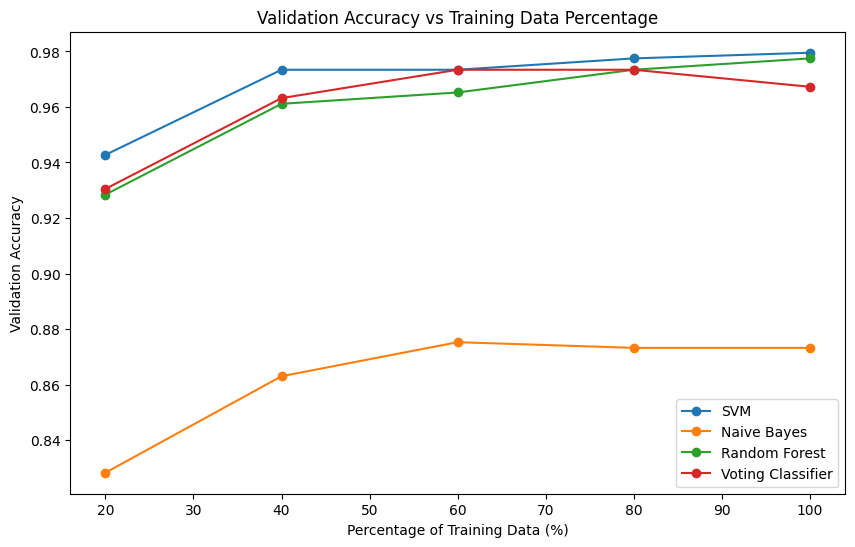

In [34]:
plt.figure(figsize=(10, 6))
plot_accuracy_vs_data(best_svm_model, 'SVM')
plot_accuracy_vs_data(nb_model, 'Naive Bayes')
plot_accuracy_vs_data(best_rf_model, 'Random Forest')
plot_accuracy_vs_data(voting_clf, 'Voting Classifier')
plt.xlabel("Percentage of Training Data (%)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Training Data Percentage")
plt.legend()
plt.show()